# Demo for a Keras Model (similar to LeNet-5) for Classification of Images. 

**For Multi-label (One image belong to several classes) Classifications:**


- Use `sigmoid` for activation of your output layer. (Don't use `softmax`.) **Why:** In softmax when increasing score for one label, all others are lowered (it's a probability distribution). You don't want that when you have multiple labels. If there's two opposite classes: for example "HAPPY" & "SAD" we should use `softmax`.
- Use `binary_crossentropy` for loss function.
- Use `predict` for evaluation.

###  The script below is used to split training data : 75% train and 25% validation. 

```
#divide all data to train and val only at the first time

import os
import shutil
import numpy as np


train_data = "data/train"
val_data = "data/val"
folders = os.listdir(train_data)

#create validation folders
for folder in folders:
    val_dir = os.path.join(val_data,folder)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
        
for folder in folders:
    train_path = os.path.join(train_data,folder)
    val_path = os.path.join(val_data,folder)

    files =  os.listdir(train_path)
    for f in files:
        if np.random.rand(1) < 0.25:
            shutil.move(train_path + '/'+ f, val_path + '/'+ f)
```





In [3]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from model_build import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
from keras.models import load_model
import imutils
import json

In [4]:
#Memory management
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

In [5]:
# Helper Functions
def get_nb_files(directory):
  """Get number of files by searching directory recursively"""
  if not os.path.exists(directory):
    return 0
  cnt = 0
  for r, dirs, files in os.walk(directory):
    for dr in dirs:
      cnt += len(glob.glob(os.path.join(r, dr + "/*")))
  return cnt

def classify(im_path, model, label_map):
    """ classifies images in a given folder using the 'model'"""
    print (im_path)
    print ("========================")
    input_img = load_img(im_path)
    img = load_img(im_path,target_size=(input_height, input_width))
    img = img_to_array(img)
    img = img.astype("float") / 255.0
    img = np.expand_dims(img, axis=0)
    
    labels = list(label_map.keys())

    predictions = model.predict(img)[0]

    plt.imshow(input_img)
    plt.show()

    for cat in labels:
        category_index = label_map[cat]
        value = predictions[category_index]
        print("{}: {:.2f}%".format(cat, value * 100))
    print ("")

## The Model (equivalent to model_build.py):

This is a linear model with 4 convolution blocks.

In [45]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # third set of CONV => RELU => POOL layers
        model.add(Conv2D(55, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))

        # Fourth set of CONV => RELU => POOL layers
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(50))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("sigmoid"))

        # return the constructed network architecture
        return model

## Inputs for training

In [6]:
#inputs for train
input_image_size = 128

# path to training dataset
train_data_dir = "data/train"

# path to validation dataset
validation_data_dir = "data/val"

# Number of Epochs (iterations)
EPOCHS = 40

In [7]:
# path to output model
model_path = "multi-label.model"
# path to output
plot_path = "plot-multi-label.png"

# learning rate
INIT_LR = 1e-3

#batch size
BS = 32

input_width = input_image_size
input_height = input_image_size

In [8]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (input_height, input_width),
    batch_size = BS,
    class_mode = "categorical"
)

Found 1515 images belonging to 5 classes.


In [10]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (input_height, input_width),
    batch_size = BS,
    class_mode = "categorical")

Found 513 images belonging to 5 classes.


In [11]:
label_map_train = (train_generator.class_indices)

In [15]:
label_map_train

{'bad_angry': 0,
 'bad_boring': 1,
 'bad_gloomy': 2,
 'good_cheerful': 3,
 'good_exciting': 4}

In [12]:
# save labels
json.dump(label_map_train, open("lebels.txt",'w'))

In [52]:
num_classes = len(label_map_train)

In [53]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=input_width , height=input_height , depth=3, classes=num_classes)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] model compiled!")

[INFO] compiling model...
[INFO] model compiled!


In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 20)      1520      
_________________________________________________________________
activation_13 (Activation)   (None, 128, 128, 20)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 50)        25050     
_________________________________________________________________
activation_14 (Activation)   (None, 64, 64, 50)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 50)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 55)        68805     
__________

In [55]:
nb_train_samples = get_nb_files(train_data_dir)
nb_validation_samples = get_nb_files(validation_data_dir)

In [56]:
# Train the model 
print("[INFO] training the model...")
H = model.fit_generator(train_generator,
                        steps_per_epoch = nb_train_samples//BS,
                        epochs = EPOCHS,
                        verbose=1,
                        validation_data = validation_generator)
print("[INFO] model trained!")
# save the model to disk
print("[INFO] serializing network...")
model.save(model_path)
print("[INFO] model saved!")

[INFO] training the model...
Epoch 1/40
47/47 [==============================] - 20s 419ms/step - loss: 0.5173 - acc: 0.7912 - val_loss: 0.5029 - val_acc: 0.8000
Epoch 2/40
47/47 [==============================] - 17s 355ms/step - loss: 0.4998 - acc: 0.8000 - val_loss: 0.5015 - val_acc: 0.8000
Epoch 3/40
47/47 [==============================] - 17s 358ms/step - loss: 0.4768 - acc: 0.8070 - val_loss: 0.4837 - val_acc: 0.8125
Epoch 4/40
47/47 [==============================] - 17s 353ms/step - loss: 0.4522 - acc: 0.8139 - val_loss: 0.4637 - val_acc: 0.8086
Epoch 5/40
47/47 [==============================] - 16s 332ms/step - loss: 0.4492 - acc: 0.8129 - val_loss: 0.5019 - val_acc: 0.8000
Epoch 6/40
47/47 [==============================] - 16s 346ms/step - loss: 0.4445 - acc: 0.8145 - val_loss: 0.4494 - val_acc: 0.8113
Epoch 7/40
47/47 [==============================] - 16s 341ms/step - loss: 0.4281 - acc: 0.8182 - val_loss: 0.4608 - val_acc: 0.8113
Epoch 8/40
47/47 [======================

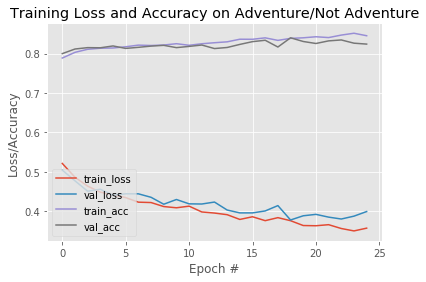

In [18]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Adventure/Not Adventure")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)
plt.show()

## Running Classification

In [16]:
# Inputs
# path to trained model
model_path = "multi-label.model"

# read labels
label_map = json.load(open("lebels.txt"))

# load the trained convolutional neural network
print("[INFO] loading network...")
model = load_model(model_path)
print ("[INFO] Loaded!")



[INFO] loading network...
[INFO] Loaded!



## Classify all images in a folder

examples\beach.jpeg


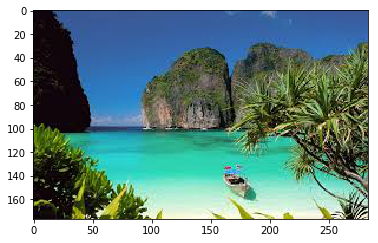

bad_angry: 0.07%
bad_boring: 0.93%
bad_gloomy: 0.14%
good_cheerful: 2.38%
good_exciting: 97.89%

examples\cry.jpg


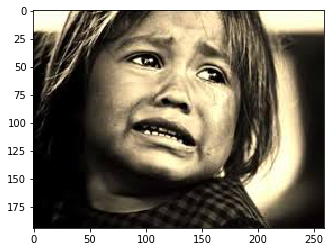

bad_angry: 17.45%
bad_boring: 19.68%
bad_gloomy: 48.69%
good_cheerful: 16.41%
good_exciting: 6.10%

examples\frustrated.jpg


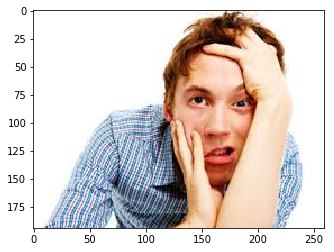

bad_angry: 56.07%
bad_boring: 13.98%
bad_gloomy: 20.61%
good_cheerful: 10.23%
good_exciting: 0.09%

examples\girl.jpeg


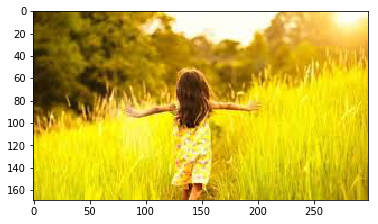

bad_angry: 3.68%
bad_boring: 26.47%
bad_gloomy: 0.01%
good_cheerful: 60.07%
good_exciting: 2.89%

examples\happy.jpg


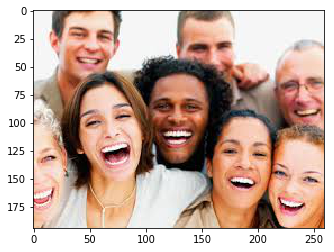

bad_angry: 45.45%
bad_boring: 26.36%
bad_gloomy: 7.15%
good_cheerful: 18.50%
good_exciting: 0.15%

examples\headache.jpeg


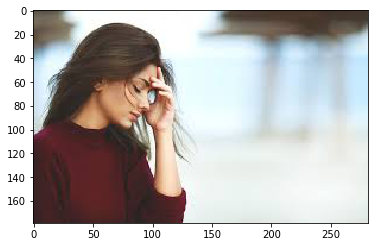

bad_angry: 56.07%
bad_boring: 20.15%
bad_gloomy: 13.23%
good_cheerful: 7.47%
good_exciting: 0.76%

examples\hike.jpeg


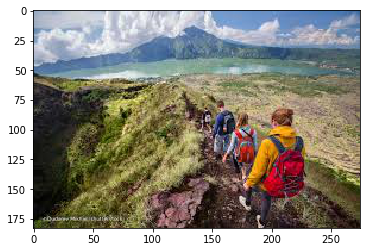

bad_angry: 0.01%
bad_boring: 0.51%
bad_gloomy: 0.05%
good_cheerful: 1.23%
good_exciting: 99.24%

examples\hike2.jpeg


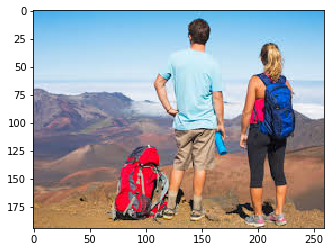

bad_angry: 0.01%
bad_boring: 1.48%
bad_gloomy: 0.01%
good_cheerful: 24.55%
good_exciting: 82.45%

examples\jump.jpeg


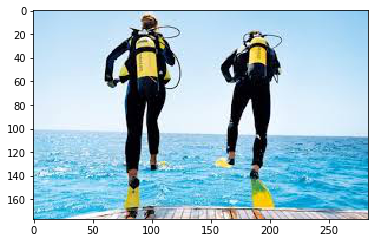

bad_angry: 6.61%
bad_boring: 10.69%
bad_gloomy: 4.03%
good_cheerful: 65.40%
good_exciting: 3.85%

examples\jump2.jpeg


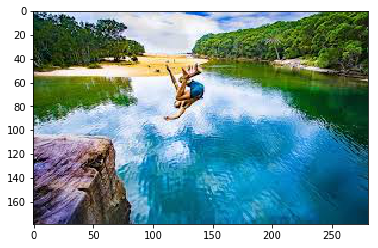

bad_angry: 0.09%
bad_boring: 24.10%
bad_gloomy: 0.12%
good_cheerful: 5.50%
good_exciting: 80.64%

examples\laugh.jpeg


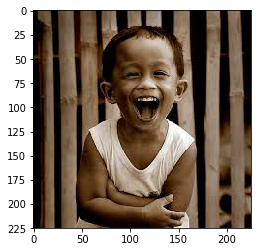

bad_angry: 14.43%
bad_boring: 53.46%
bad_gloomy: 20.10%
good_cheerful: 23.11%
good_exciting: 3.22%

examples\manhattan.png


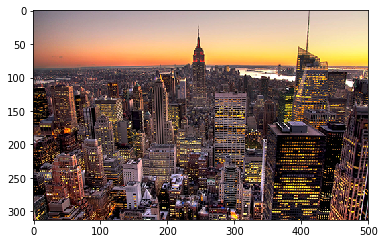

bad_angry: 0.03%
bad_boring: 6.61%
bad_gloomy: 0.46%
good_cheerful: 7.35%
good_exciting: 91.50%

examples\night_sky.png


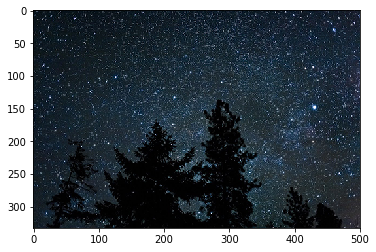

bad_angry: 15.50%
bad_boring: 2.37%
bad_gloomy: 69.31%
good_cheerful: 3.78%
good_exciting: 13.75%

examples\sad.jpeg


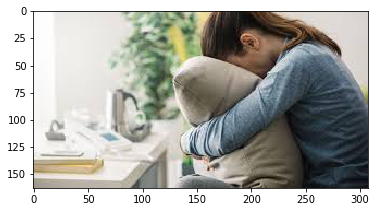

bad_angry: 19.08%
bad_boring: 23.05%
bad_gloomy: 44.15%
good_cheerful: 7.67%
good_exciting: 4.18%

examples\sampleb_015.jpg


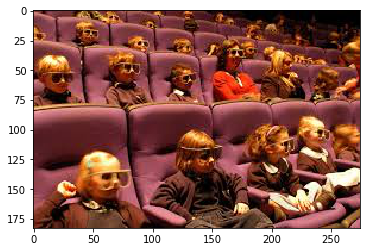

bad_angry: 3.55%
bad_boring: 64.38%
bad_gloomy: 2.71%
good_cheerful: 10.35%
good_exciting: 11.08%

examples\sampleb_022.jpg


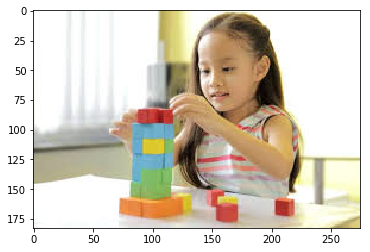

bad_angry: 20.67%
bad_boring: 44.52%
bad_gloomy: 12.70%
good_cheerful: 21.69%
good_exciting: 0.81%

examples\sampleb_023.jpg


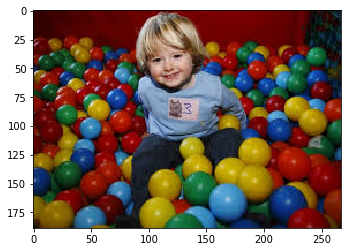

bad_angry: 71.69%
bad_boring: 20.42%
bad_gloomy: 0.86%
good_cheerful: 31.85%
good_exciting: 2.95%

examples\sampleb_026.jpg


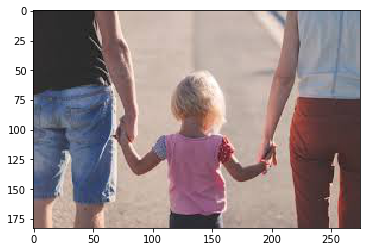

bad_angry: 12.46%
bad_boring: 41.88%
bad_gloomy: 24.76%
good_cheerful: 16.31%
good_exciting: 13.48%

examples\sampleb_041.jpg


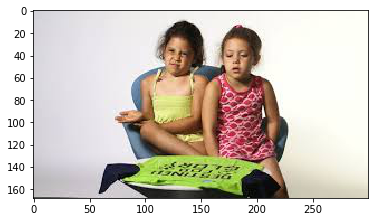

bad_angry: 73.78%
bad_boring: 10.79%
bad_gloomy: 3.36%
good_cheerful: 26.49%
good_exciting: 1.01%

examples\santa_01.png


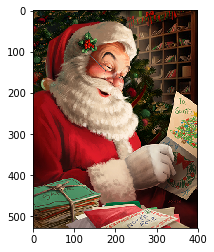

bad_angry: 3.00%
bad_boring: 58.53%
bad_gloomy: 8.55%
good_cheerful: 4.95%
good_exciting: 9.70%

examples\santa_02.jpg


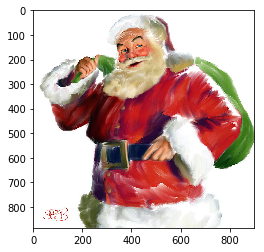

bad_angry: 34.52%
bad_boring: 36.41%
bad_gloomy: 6.97%
good_cheerful: 29.80%
good_exciting: 0.08%

examples\sleeping.jpeg


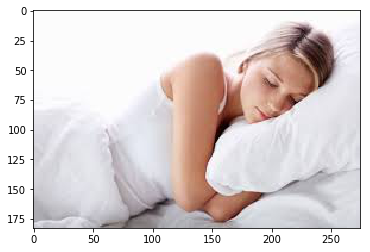

bad_angry: 12.80%
bad_boring: 42.17%
bad_gloomy: 8.45%
good_cheerful: 36.50%
good_exciting: 3.54%

examples\sleeping2.jpeg


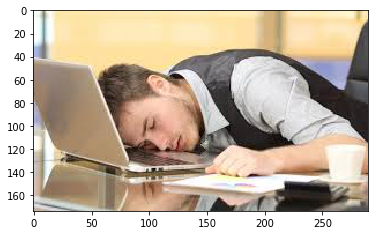

bad_angry: 8.03%
bad_boring: 64.66%
bad_gloomy: 14.65%
good_cheerful: 17.75%
good_exciting: 0.54%

examples\sleepy.jpeg


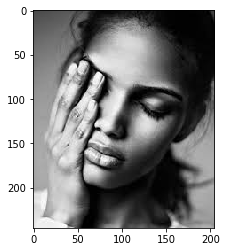

bad_angry: 17.63%
bad_boring: 8.04%
bad_gloomy: 57.60%
good_cheerful: 8.16%
good_exciting: 0.20%

examples\stressed.jpeg


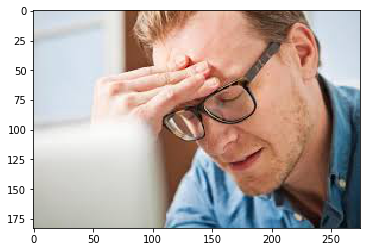

bad_angry: 43.96%
bad_boring: 10.79%
bad_gloomy: 41.89%
good_cheerful: 6.00%
good_exciting: 0.19%

examples\tiger.jpeg


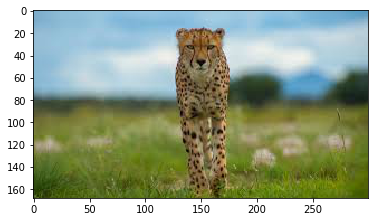

bad_angry: 0.15%
bad_boring: 0.50%
bad_gloomy: 0.10%
good_cheerful: 4.99%
good_exciting: 97.17%

examples\water.jpeg


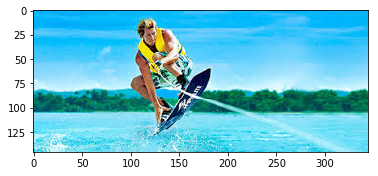

bad_angry: 0.01%
bad_boring: 0.35%
bad_gloomy: 0.00%
good_cheerful: 4.08%
good_exciting: 96.70%

examples\waterfall.jpeg


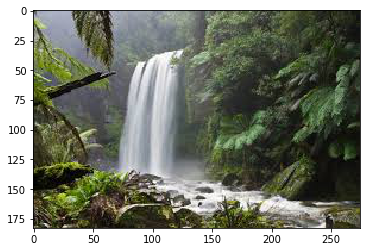

bad_angry: 0.81%
bad_boring: 6.22%
bad_gloomy: 5.59%
good_cheerful: 4.67%
good_exciting: 88.68%

examples\work.jpeg


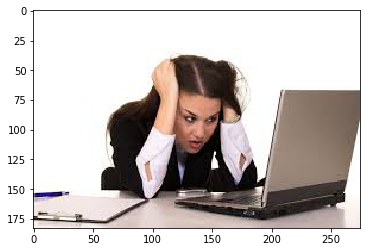

bad_angry: 25.62%
bad_boring: 33.60%
bad_gloomy: 12.23%
good_cheerful: 10.54%
good_exciting: 0.04%



In [17]:
# path to input image directory
image_dir = "examples"

image_paths = list(paths.list_images(image_dir))

for img in image_paths:
    classify(img, model, label_map)

## Classify a Single Image

examples/sleeping.jpeg


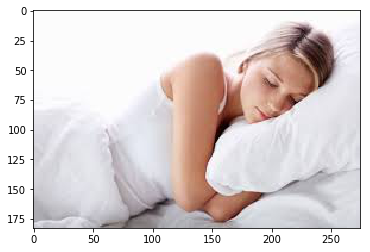

bad_angry: 12.80%
bad_boring: 42.17%
bad_gloomy: 8.45%
good_cheerful: 36.50%
good_exciting: 3.54%



In [19]:
image_path = "examples/sleeping.jpeg"
classify(image_path, model, label_map)